In [99]:
import os
import subprocess

def install(package):
    subprocess.run(f'pip install {package}', shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

install('--upgrade pip setuptools wheel')
install('cython')
install('pyyaml')
install('scipy')
install('pycaret[full]')
install('catboost')
install('xgboost')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pycaret.classification import setup, compare_models, finalize_model, save_model, load_model, predict_model

file_path = '/Users/sherryzhang/Downloads/Final_Balanced_Data.csv'
data = pd.read_csv(file_path)

poverty_threshold = 13590
data['poverty_status'] = np.where(data['PINCP'] <= poverty_threshold, 1, 0)

data = data.drop(columns=['PINCP'])

X = data.drop(columns=['poverty_status'])
Y = data['poverty_status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18)

train_data = pd.concat([pd.DataFrame(X_train), pd.Series(Y_train, name='poverty_status')], axis=1)
clf_setup = setup(data=train_data, target='poverty_status', session_id=123)

best_model = compare_models()
print("Best Model: ", best_model)

final_model = finalize_model(best_model)

test_data = pd.concat([pd.DataFrame(X_test), pd.Series(Y_test, name='poverty_status')], axis=1)
predictions_df = predict_model(final_model, data=test_data)

predictions = predictions_df['poverty_status']

accuracy = accuracy_score(Y_test, predictions)
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)
conf_matrix = confusion_matrix(Y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

,Description,Value
0,Session id,123
1,Target,poverty_status
2,Target type,Binary
3,Original data shape,"(666928, 16)"
4,Transformed data shape,"(666928, 16)"
5,Transformed train set shape,"(466849, 16)"
6,Transformed test set shape,"(200079, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8149,0.8942,0.7889,0.8323,0.8100,0.6297,0.6306,15.3410
xgboost,Extreme Gradient Boosting,0.8136,0.8930,0.7885,0.8305,0.8089,0.6273,0.6281,0.5890
lightgbm,Light Gradient Boosting Machine,0.8125,0.8917,0.7857,0.8304,0.8074,0.6250,0.6259,5.8930
rf,Random Forest Classifier,0.8045,0.8819,0.7757,0.8232,0.7988,0.6089,0.6099,5.9240
gbc,Gradient Boosting Classifier,0.8045,0.8843,0.7553,0.8379,0.7945,0.6090,0.6120,5.0730
ada,Ada Boost Classifier,0.7996,0.8758,0.7570,0.8277,0.7908,0.5992,0.6014,1.1580
et,Extra Trees Classifier,0.7937,0.8708,0.7650,0.8118,0.7877,0.5874,0.5883,9.0440
lr,Logistic Regression,0.7738,0.8444,0.7655,0.7786,0.7720,0.5476,0.5477,2.3750
ridge,Ridge Classifier,0.7728,0.8456,0.7483,0.7871,0.7672,0.5457,0.5463,0.0710
lda,Linear Discriminant Analysis,0.7728,0.8456,0.7483,0.7871,0.7672,0.5457,0.5463,0.2660


Best Model:  <catboost.core.CatBoostClassifier object at 0x377a371d0>


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8154,0.8945,0.7893,0.8320,0.8101,0.6308,0.6317


Accuracy: 0.8154343497349039
Precision: 0.8320402626708248
Recall: 0.789266087040177
F1 Score: 0.8100889292084005
Confusion Matrix: 
[[70326 13249]
 [17524 65633]]


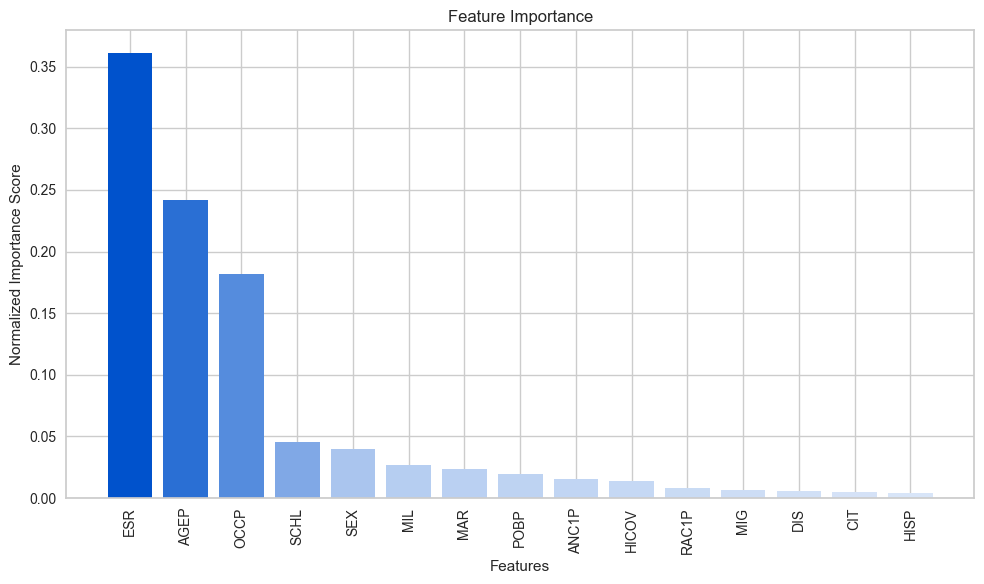

Feature Importances:
ESR: 0.3614
AGEP: 0.2419
OCCP: 0.1818
SCHL: 0.0451
SEX: 0.0401
MIL: 0.0265
MAR: 0.0237
POBP: 0.0195
ANC1P: 0.0158
HICOV: 0.0143
RAC1P: 0.0085
MIG: 0.0063
DIS: 0.0056
CIT: 0.0051
HISP: 0.0044


In [100]:
import matplotlib.pyplot as plt
import numpy as np

base_color = '#0052cc'

def lighten_color(color, amount):
    """
    Lightens the given color by the specified amount.
    0.0 gives the original color, 1.0 gives white.
    """
    import matplotlib.colors as mcolors
    c = np.array(mcolors.to_rgb(color))
    white = np.array([1, 1, 1])
    return mcolors.to_hex((1 - amount) * c + amount * white)

if hasattr(final_model, 'feature_importances_'):
    feature_importance = final_model.feature_importances_
    total_importance = sum(feature_importance)
    normalized_importance = feature_importance / total_importance

    indices = np.argsort(normalized_importance)[::-1]
    names = [X.columns[i] for i in indices]

    num_features = len(normalized_importance)
    first_five_shades = [lighten_color(base_color, amount=i/6) for i in range(5)]
   
    last_first_shade = lighten_color(first_five_shades[-1], amount=0.1)
    remaining_shades = [lighten_color(last_first_shade, amount=(i-4)/(num_features-5)*0.5) for i in range(5, num_features)]
    bar_colors = first_five_shades + remaining_shades

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(normalized_importance)), normalized_importance[indices], align='center', color=bar_colors)
    plt.xticks(range(len(normalized_importance)), names, rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Normalized Importance Score')
    plt.tight_layout()
    plt.show()


    print("Feature Importances:")
    for name, importance in zip(names, normalized_importance[indices]):
        print(f"{name}: {importance:.4f}")
else:
    print("The selected model does not provide feature importances.")

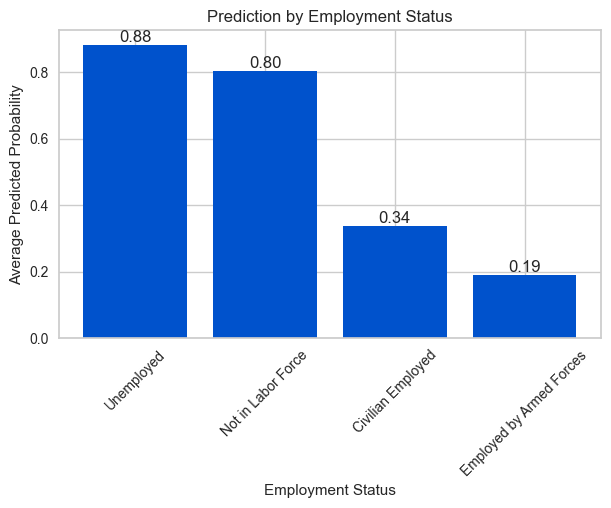

In [106]:
import matplotlib.pyplot as plt

ESR_groups = [(1, 2, 'Civilian Employed'), (3, 3, 'Unemployed'), (4, 5, 'Employed by Armed Forces'), (6, 6, 'Not in Labor Force')]

avg_probs = []
labels = []

for start, end, label in ESR_groups:
    subset_indices = (X_test['ESR'] >= start) & (X_test['ESR'] <= end)
    subset_X = X_test[subset_indices]
    subset_Y = Y_test[subset_indices]
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)
    labels.append(label)

sorted_indices = sorted(range(len(avg_probs)), key=lambda i: avg_probs[i], reverse=True)
sorted_avg_probs = [avg_probs[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

plt.figure(figsize=(7, 4))
bars = plt.bar(sorted_labels, sorted_avg_probs, color='#0052cc')
plt.xlabel("Employment Status")
plt.ylabel("Average Predicted Probability")
plt.title("Prediction by Employment Status")
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()

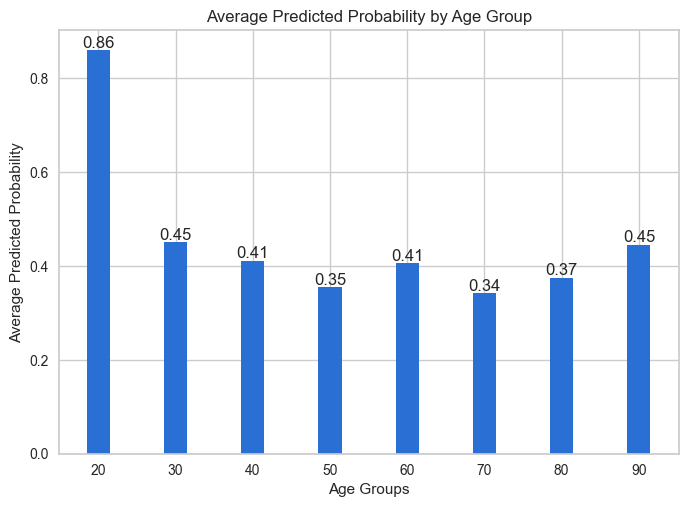

In [107]:
import matplotlib.pyplot as plt

# Example age groups
age_groups = [20, 30, 40, 50, 60, 70, 80, 90]
avg_probs = []

for age in age_groups:
    subset_indices = X_test['AGEP'] == age
    subset_X = X_test[subset_indices]
    subset_Y = Y_test[subset_indices]
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)

bar_width = 3
plt.bar(age_groups, avg_probs, width=bar_width, color='#2a6fd4')
plt.xlabel("Age Groups")
plt.ylabel("Average Predicted Probability")
plt.title("Average Predicted Probability by Age Group")

for i, prob in enumerate(avg_probs):
    plt.text(age_groups[i], prob, f'{prob:.2f}', ha='center', va='bottom')

plt.show()

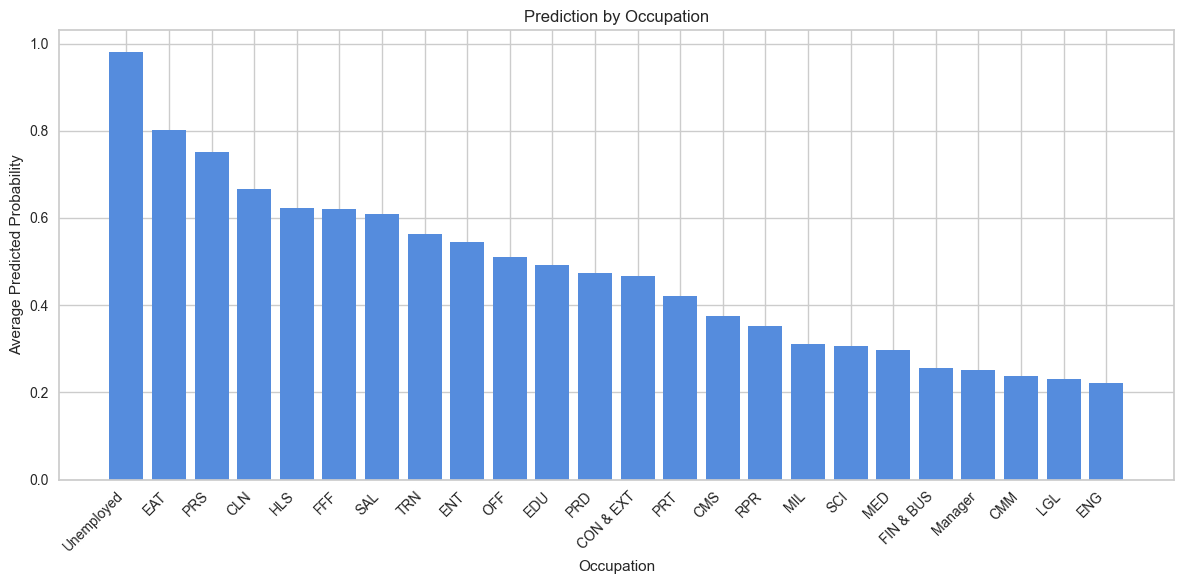

Unemployed:0.9810
EAT:0.8027
PRS:0.7505
CLN:0.6671
HLS:0.6224
FFF:0.6208
SAL:0.6096
TRN:0.5624
ENT:0.5442
OFF:0.5106
EDU:0.4922
PRD:0.4736
CON & EXT:0.4672
PRT:0.4211
CMS:0.3751
RPR:0.3513
MIL:0.3103
SCI:0.3063
MED:0.2966
FIN & BUS:0.2549
Manager:0.2511
CMM:0.2388
LGL:0.2316
ENG:0.2212


In [108]:
import matplotlib.pyplot as plt

OCCPs = [(10, 440, "Manager"), (500, 960, "FIN & BUS"),
         (1005, 1240, "CMM"),
         (1305, 1560, "ENG"),
         (1600, 1980, "SCI"),
         (2001, 2060, "CMS"),
         (2100, 2180, "LGL"),
         (2205, 2555, "EDU"),
         (2600, 2920, "ENT"),
         (3000, 3550, "MED"),
         (3601, 3655, "HLS"),
         (3700, 3960, "PRT"),
         (4000, 4160, "EAT"),
         (4200, 4255, "CLN"),
         (4330, 4655, "PRS"),
         (4700, 4965, "SAL"),
         (5000, 5940, "OFF"),
         (6005, 6130, "FFF"),
         (6200, 6950, "CON & EXT"),
         (7000, 7640, "RPR"),
         (7700, 8990, "PRD"),
         (9005, 9760, "TRN"),
         (9800, 9830, "MIL"),
         (9920, 9920, "Unemployed")]

avg_probs = []
occupations = []

for OCCP in OCCPs:
    subset_indices = (X_test['OCCP'] >= OCCP[0]) & (X_test['OCCP'] <= OCCP[1])
    subset_X = X_test.loc[subset_indices]

    subset_Y = Y_test[subset_indices]
    
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)

    occupations.append(OCCP[2])

avg_probs, occupations = zip(*sorted(zip(avg_probs, occupations), reverse=True))

plt.figure(figsize=(12, 6))
bars = plt.bar(occupations, avg_probs, color='#558cdd')

plt.xlabel("Occupation")
plt.ylabel("Average Predicted Probability")
plt.title("Prediction by Occupation")
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

for occupation, avg_prob in zip(occupations, avg_probs):
    print(f"{occupation}:{avg_prob:.4f}")

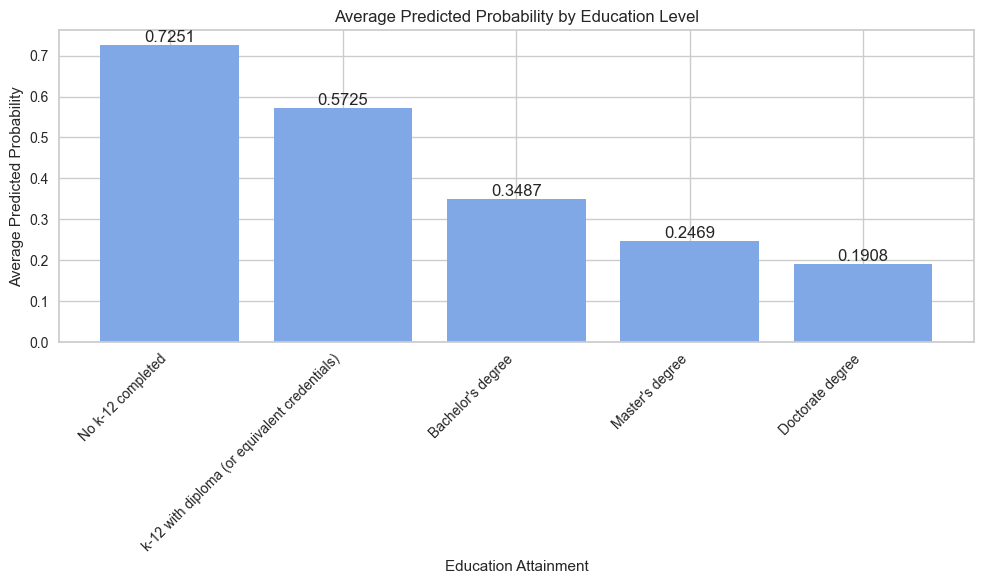

In [109]:
import matplotlib.pyplot as plt

EduLvl = [
    (1, 15, "No k-12 completed"),
    (16, 17, "k-12 with diploma (or equivalent credentials)"),
    (21, 21, "Bachelor's degree"),
    (22, 22, "Master's degree"),
    (24, 24, "Doctorate degree")
]

avg_probs = []
edu_lvls = [] 

for SCHL in EduLvl:
    subset_indices = (X_test['SCHL'] >= SCHL[0]) & (X_test['SCHL'] <= SCHL[1])
    subset_X = X_test[subset_indices]
    subset_Y = Y_test[subset_indices]
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean()
    avg_probs.append(avg_prob)
    edu_lvls.append(SCHL[2]) 

plt.figure(figsize=(10, 6))
bars = plt.bar(edu_lvls, avg_probs, color='#80a8e6')
plt.xlabel("Education Attainment")
plt.ylabel("Average Predicted Probability")
plt.title("Average Predicted Probability by Education Level")
plt.xticks(rotation=45, ha='right') 

for bar, avg_prob in zip(bars, avg_probs):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

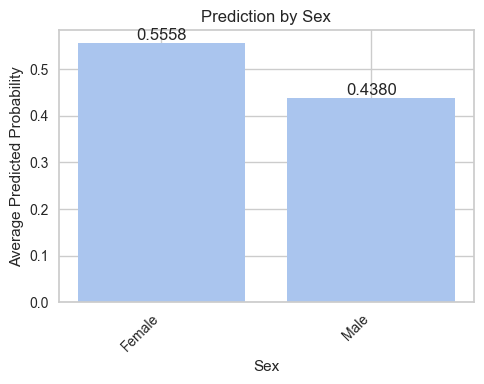

In [111]:
import matplotlib.pyplot as plt

Sex = [
    (1, 1, "Male"),
    (2, 2, "Female"),
]

avg_probs = []
sex_labels = []

for start, end, label in Sex:
    subset_indices = (X_test['SEX'] >= start) & (X_test['SEX'] <= end) 
    subset_X = X_test[subset_indices]
    avg_prob = final_model.predict_proba(subset_X)[:, 1].mean() if len(subset_X) > 0 else 0  
    avg_probs.append(avg_prob)
    sex_labels.append(label)

sorted_indices = sorted(range(len(avg_probs)), key=lambda i: avg_probs[i], reverse=True)
sorted_avg_probs = [avg_probs[i] for i in sorted_indices]
sorted_sex_labels = [sex_labels[i] for i in sorted_indices]

plt.figure(figsize=(5, 4))
bars = plt.bar(sorted_sex_labels, sorted_avg_probs, color='#aac5ee')
plt.xlabel("Sex")
plt.ylabel("Average Predicted Probability")
plt.title("Prediction by Sex")
plt.xticks(rotation=45, ha='right')

for bar, avg_prob in zip(bars, sorted_avg_probs):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()